In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cortex as cx
import nilearn.surface as surface
import pandas as pd
import numpy as np
import os, shutil, shlex, subprocess
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib import cm

# needs prfpy for prf spatial plot, and for model predictions at some point
from prfpy.rf import gauss2D_iso_cart
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel, Norm_Iso2DGaussianModel, DoG_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter, Norm_Iso2DGaussianFitter, DoG_Iso2DGaussianFitter
from prfpy.stimulus import PRFStimulus2D, CFStimulus
import IPython

from prfpy.utils import Subsurface
from prfpy.stimulus import CFStimulus
from prfpy.model import CFGaussianModel
from prfpy.fit import CFFitter
from prfpy.model import Norm_CFGaussianModel
from prfpy.fit import Norm_CFGaussianFitter

import scipy as sp
import nilearn as nl
from nilearn.surface import load_surf_data
import urllib.request
from matplotlib import rc
import nibabel as nb
from nibabel import cifti2

import prfpy
from scipy.io import loadmat
from prfpy.rf import *
from prfpy.timecourse import *
from prfpy.utils import Subsurface
from prfpy.model import CFGaussianModel
from prfpy.fit import CFFitter, Norm_CFGaussianFitter
from scipy.optimize import LinearConstraint, NonlinearConstraint
import natsort


/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [3]:
def angle(x0, y0):
    return np.angle(x0 + y0 * 1j)

def ecc(x0, y0):
    return np.abs(x0 + y0 * 1j)
  
    
idxs = h5py.File('/tank/shared/timeless/atlases/cifti_indices.hdf5', "r")
lidxs = np.array(idxs['Left_indices'])
ridxs = np.array(idxs['Right_indices'])

def get_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

    data = np.concatenate([l, r])
    return data

In [4]:
flatmap_height = 2048
full_figsize = (9, 11)

vf_extent = [-8, 8]
nr_vf_pix = 200
prf_space_x, prf_space_y = np.meshgrid(np.linspace(vf_extent[0], vf_extent[1], nr_vf_pix, endpoint=True),
                                       np.linspace(vf_extent[0], vf_extent[1], nr_vf_pix, endpoint=True))\


subject='hcp_999999'
mask, extents = cx.quickflat.utils.get_flatmask(subject, height=flatmap_height)
vc = cx.quickflat.utils._make_vertex_cache(subject, height=flatmap_height)

mask_index = np.zeros(mask.shape)
mask_index[mask] = np.arange(mask.sum())

In [5]:
sos = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/hcp-dataset_utils/prf_dm.npy')
new_dms = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/hcp-dataset_utils/prf_dm.npy')[5:,:,:]


In [6]:
import pandas as pd
import numpy as np

psub = 2
fold = 1

brainmask = np.load(f'/tank/klundert/DMs/brainmask_sub-0{psub}.npy')
zsc_data = get_cortex(np.load(f'/tank/klundert/fit_data/fit_data/data_fold2_detrend_sub-0{psub}_zsc_hcp.npy'))
psc_data = get_cortex(np.load(f'/tank/klundert/fit_data/fit_data/data_fold2_detrend_sub-0{psub}_psc_hcp.npy'))

prf_gauss = get_cortex(np.load(f'/tank/klundert/data_hcp-space_cf/pRF-params_sub-0{psub}_gauss_weighted_fold-0{fold}.npy'))
prf_gauss[~brainmask] = np.nan
# Create a list of parameter names
parameter_names = ['x', 'y', 'pRF size', 'amplitude', 'bold-baseline', 'hrf1', 'hrf2', 'rsq']

# Create a Pandas dataframe and set the column names to the parameter names
prf_gauss = pd.DataFrame(prf_gauss, columns=parameter_names)

# Set the index to be the measurement number
prf_gauss.index = range(prf_gauss.shape[0])

# Print the resulting dataframe
# print(prf_gauss)

prf_dn = get_cortex(np.load(f'/tank/klundert/data_hcp-space_cf/pRF-params_sub-0{psub}_norm_weighted_fold-0{fold}.npy'))
prf_dn[~brainmask] = np.nan

parameter_names = ['x', 'y', 'pRF size', 'amplitude', 'bold baseline', 'surr amp', 'surr size', 'B', 'D', 'hrf1', 'hrf2', 'rsq']
prf_dn = pd.DataFrame(prf_dn, columns=parameter_names)
prf_dn.index = range(prf_dn.shape[0])

cf_gauss = np.zeros([118584, 7])
cf_gauss[:] = np.nan
cf_gauss[brainmask] = np.load(f'/tank/klundert/data_hcp-space_cf/CF-params_sub-0{psub}_gauss_weighted_fullbrain_fold-0{fold}.npy')
parameter_names = ['cf size', 'cf amp', 'bold baseline', 'vert', 'rsq', 'x', 'y']
cf_gauss = pd.DataFrame(cf_gauss, columns=parameter_names)
cf_gauss.index = range(cf_gauss.shape[0])

cf_dn = np.zeros([118584, 11])
cf_dn[:] = np.nan
cf_dn[brainmask] = np.load(f'/tank/klundert/data_hcp-space_cf/CF-params_sub-0{psub}_norm_weighted_fullbrain_fold-0{fold}.npy')
parameter_names = ['cf size', 'cf amp', 'bold baseline', 'vert', 'surr amp', 'surr size', 'B', 'D', 'rsq', 'x', 'y']
cf_dn = pd.DataFrame(cf_dn, columns=parameter_names)
cf_dn.index = range(cf_dn.shape[0])


In [7]:
# set up models to create model predictions for plotting

subsurface_verts = np.load(f'/tank/klundert/DMs/subsurface_verts_sub-0{psub}_hcp_NoR2.npy')
distance_matrix = np.load(f'/tank/klundert/DMs//distance_matrix_sub-0{psub}_hcp_NoR2.npy')
mydat_train_stim = get_cortex(np.load(f'/tank/klundert/fit_data/fit_data/data_fold2_detrend_sub-0{psub}_zsc_hcp.npy'))
train_stim3=CFStimulus(mydat_train_stim, subsurface_verts, distance_matrix)
modelG=CFGaussianModel(train_stim3)
modelDN=Norm_CFGaussianModel(train_stim3)


s2_f = get_cortex(np.load('/tank/klundert/fit_data/fit_data/data_fold2_detrend_sub-02_psc_hcp.npy'))
new_dms = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/hcp-dataset_utils/prf_dm.npy')[5:,:,:]

prf_stim = PRFStimulus2D(screen_size_cm=69, 
                         screen_distance_cm=220, 
                         design_matrix=new_dms.T, 
                         TR=1.5)

grid_nr = 20
max_ecc_size = prf_stim.screen_size_degrees/2.0
sizes, eccs, polars = max_ecc_size * np.linspace(0.25, 1, grid_nr)**2, \
    max_ecc_size * np.linspace(0.1, 1, grid_nr)**2, \
    np.linspace(0, 2*np.pi, grid_nr)

# to set up parameter bounds in iterfit
inf = np.inf
eps = 1e-1
ss = prf_stim.screen_size_degrees

gg = Iso2DGaussianModel(stimulus=prf_stim,
                        filter_predictions=False,
                        filter_type='dc')


gg_norm = Norm_Iso2DGaussianModel(stimulus=prf_stim,
                                    filter_predictions=False,
                                    filter_type='dc',
                                    )

In [8]:
vertex = 27734

prf = gauss2D_iso_cart(prf_space_x,
                       prf_space_y,
                       [prf_dn['x'][vertex],
                        prf_dn['y'][vertex]],
                       prf_dn['pRF size'][vertex])


# prf_ax.clear()
# prf_ax.imshow(prf, extent=vf_extent+vf_extent, cmap='cubehelix')
# prf_ax.axvline(0, color='white', linestyle='dashed', lw=0.5)
# prf_ax.axhline(0, color='white', linestyle='dashed', lw=0.5)
# prf_ax.set_title(f"x: {x[vertex]}, y: {y[vertex]}")

In [9]:
# ## subject = 'hcp_999999'
# %matplotlib notebook


# full_fig = plt.figure(constrained_layout=True, figsize=full_figsize)
# gs = full_fig.add_gridspec(4, 3)
# flatmap_ax = full_fig.add_subplot(gs[:2, :])
# timecourse_ax = full_fig.add_subplot(gs[2, :2])
# prf_ax = full_fig.add_subplot(gs[2, 2])
# flatmap_ax.set_title('flatmap')
# timecourse_ax.set_title('timecourse')
# prf_ax.set_title('prf')

# timecourse_ax2 = full_fig.add_subplot(gs[3, :2])
# timecourse_ax2.set_title('timecourse2')


# ###################################################################################################
# ###################################################################################################
# #######
# # redraw per-vertex data
# #######
# ###################################################################################################
# ###################################################################################################

# def redraw_vertex_plots(vertex, refresh):
#     if refresh:
#         timecourse_ax.clear()
#     timecourse_ax.axhline(0, color='black', lw=0.25)
#     timecourse_ax.plot(psc_data[vertex], label = f'psc {vertex}')
#     timecourse_ax.plot(gg.return_prediction(*np.array(prf_gauss)[vertex,:-1].T).T, label = 'gauss prf')
#     timecourse_ax.plot(gg_norm.return_prediction(*np.array(prf_dn)[vertex,:-1].T).T, label = f'DN prf')
#     timecourse_ax.legend(loc="upper left")
    
#     if refresh:
#         timecourse_ax2.clear()
#     timecourse_ax2.axhline(0, color='black', lw=0.25)
#     timecourse_ax2.plot(psc_data[vertex], label = f'psc {vertex}')
#     timecourse_ax2.plot(modelG.return_prediction(*np.array(cf_gauss)[vertex,:-3].T).T, label = f'gauss cf')
#     timecourse_ax2.plot(modelDN.return_prediction(*np.array(cf_dn)[vertex,:-3].T).T, label = f'DN cf')
#     timecourse_ax2.legend(loc="upper left")
    
# #     timecourse_ax2.plot(gg.return_prediction(*gaussparams[vertex,:-1].T).T, label = 'gauss timecourse')
# #     timecourse_ax.set_title(f'(dn: {rvals_dn[vertex,-1]}, gauss: {rvals_gauss[vertex,-1]}')
# #     timecourse_ax.plot(sos, alpha=0.125, lw=3, color='gray')
# #     timecourse_ax.plot(np.roll(sos,5), alpha=0.25, ls=':', lw=3, color='gray')


#     prf = gauss2D_iso_cart(prf_space_x,
#                        prf_space_y,
#                        [prf_dn['x'][vertex],
#                         prf_dn['y'][vertex]],
#                        prf_dn['pRF size'][vertex])
#     prf_ax.clear()
#     prf_ax.imshow(prf, extent=vf_extent+vf_extent, cmap='cubehelix')
#     prf_ax.axvline(0, color='white', linestyle='dashed', lw=0.5)
#     prf_ax.axhline(0, color='white', linestyle='dashed', lw=0.5)
#     prf_ax.set_title(f"x: {prf_dn['x'][vertex]}, y: {prf_dn['y'][vertex]}")

# def zoom_to_roi(axis, subject, roi, hem, margin=10.0):
#     roi_verts = cx.get_roi_verts(subject, roi)[roi]
#     roi_map = cx.Vertex.empty(subject)
#     roi_map.data[roi_verts] = 1

#     (lflatpts, lpolys), (rflatpts, rpolys) = cx.db.get_surf(subject, "flat",
#                                                             nudge=True)
#     sel_pts = dict(left=lflatpts, right=rflatpts)[hem]
#     roi_pts = sel_pts[np.nonzero(getattr(roi_map, hem))[0], :2]

#     xmin, ymin = roi_pts.min(0) - margin
#     xmax, ymax = roi_pts.max(0) + margin
#     print([xmin, xmax, ymin, ymax])
#     axis.axis([xmin, xmax, ymin, ymax])

#     return [xmin, xmax, ymin, ymax]

# ###################################################################################################
# ###################################################################################################
# #######
# # actual callback functions
# #######
# ###################################################################################################
# ###################################################################################################

# def onclick(event):
#     if event.inaxes == flatmap_ax:
#         xmin, xmax = flatmap_ax.get_xbound()
#         ax_xrange = xmax-xmin
#         ymin, ymax = flatmap_ax.get_ybound()
#         ax_yrange = ymax-ymin

#         rel_x = int(mask.shape[0] * (event.xdata-xmin)/ax_xrange)
#         rel_y = int(mask.shape[1] * (event.ydata-ymin)/ax_yrange)
#         clicked_pixel = (rel_x, rel_y)

#         clicked_vertex = vc[int(
#             mask_index[clicked_pixel[0], clicked_pixel[1]])]

#         redraw_vertex_plots(clicked_vertex.indices[0], (event.key == 'shift'))
#         plt.draw()

# def onkey(event):
#     if event.key == '1':  # polar angle
#         cx.quickshow(cx.Vertex2D(cf_dn['rsq'], prf_dn['rsq'], subject='hcp_999999', vmin=0, vmax=1, vmin2=0, vmax2=1), with_curvature=True,
#              fig=flatmap_ax, with_colorbar=False)
#         flatmap_ax.set_title('Rvals cf & prf DN')
#     elif event.key == '2':  
#         cx.quickshow(cx.Vertex(np.array(cf_dn['rsq']-cf_gauss['rsq']), subject, cmap='spectral_r', vmin=-0.1, vmax=0.1), with_curvature=True,
#              fig=flatmap_ax, with_colorbar=False)
#         flatmap_ax.set_title('Rsq CF DN - gauss')
#     elif event.key == '3':  
#         cx.quickshow(cx.Vertex2D(np.log(cf_dn['B']), cf_dn['rsq'], subject, cmap='fire_alpha', vmin=0, vmin2=0,vmax2=1), with_curvature=True,
#              fig=flatmap_ax, with_colorbar=False)
#         flatmap_ax.set_title('CF B param')
#     elif event.key == '4': 
#         cx.quickshow(cx.Vertex2D(np.log(prf_dn['B']), prf_dn['rsq'], subject, cmap='fire_alpha', vmin=0, vmin2=0,vmax2=1), with_curvature=True,
#              fig=flatmap_ax, with_colorbar=False)
#         flatmap_ax.set_title('pRF B param')
#     elif event.key == '5': 
#         cx.quickshow(cx.Vertex2D(np.log(cf_dn['D']), cf_dn['rsq'], subject, cmap='plasma_alpha', vmin=0, vmin2=0,vmax2=1), with_curvature=True,
#              fig=flatmap_ax, with_colorbar=False)
#         flatmap_ax.set_title('CF D param')
#     elif event.key == '6': 
#         cx.quickshow(cx.Vertex2D(np.log(prf_dn['D']), prf_dn['rsq'], subject, cmap='plasma_alpha', vmin=0, vmin2=0,vmax2=1), with_curvature=True,
#              fig=flatmap_ax, with_colorbar=False)
#         flatmap_ax.set_title('pRF D param')
#     elif event.key == '7':  # ecc
#         cx.quickshow(cx.Vertex(np.array(ecc(prf_dn['x'], prf_dn['y'])), subject, cmap='nipy_spectral', vmin=0, vmax=8.4), with_curvature=True,
#              fig=flatmap_ax, with_colorbar=False)
#         flatmap_ax.set_title('eccentricity')
# #     elif event.key == '8':  
# #         cx.quickshow(cx.Vertex(b_param, subject, cmap='inferno', vmin=0), with_curvature=True,
# #              fig=flatmap_ax, with_colorbar=False)             
# #         flatmap_ax.set_title('b_param')        
# #     elif event.key == '9':  # d_param
# #         cx.quickshow(cx.Vertex(d_param, subject, cmap='inferno', vmin=0), with_curvature=True,
# #              fig=flatmap_ax, with_colorbar=False)   
# #         flatmap_ax.set_title('d_param')    
# #     elif event.key == '8':  # mean_epi
# #         cx.quickshow(cx.Vertex(mean_epi, subject='hcp_999999', cmap='YlOrRd'), with_curvature=True,
# #              fig=flatmap_ax, with_colorbar=False)   
# #         flatmap_ax.set_title('EPI')    
#     plt.draw()
    
# ###################################################################################################
# ###################################################################################################
# #######
# # start
# #######
# ###################################################################################################
# ###################################################################################################
# # start with rvals.
# cx.quickshow(cx.Vertex2D(cf_dn['rsq'], prf_dn['rsq'], subject='hcp_999999', vmin=0, vmax=1, vmin2=0, vmax2=1), with_curvature=True,
#              fig=flatmap_ax, with_colorbar=False)



# # new_bounds  = zoom_to_roi(axis=flatmap_ax, subject=subject,
# #             roi='V2', hem='left', margin=10.0)

# full_fig.canvas.mpl_connect('button_press_event', onclick)
# full_fig.canvas.mpl_connect('key_press_event', onkey)
# plt.show()
# plt.ion()


<IPython.core.display.Javascript object>


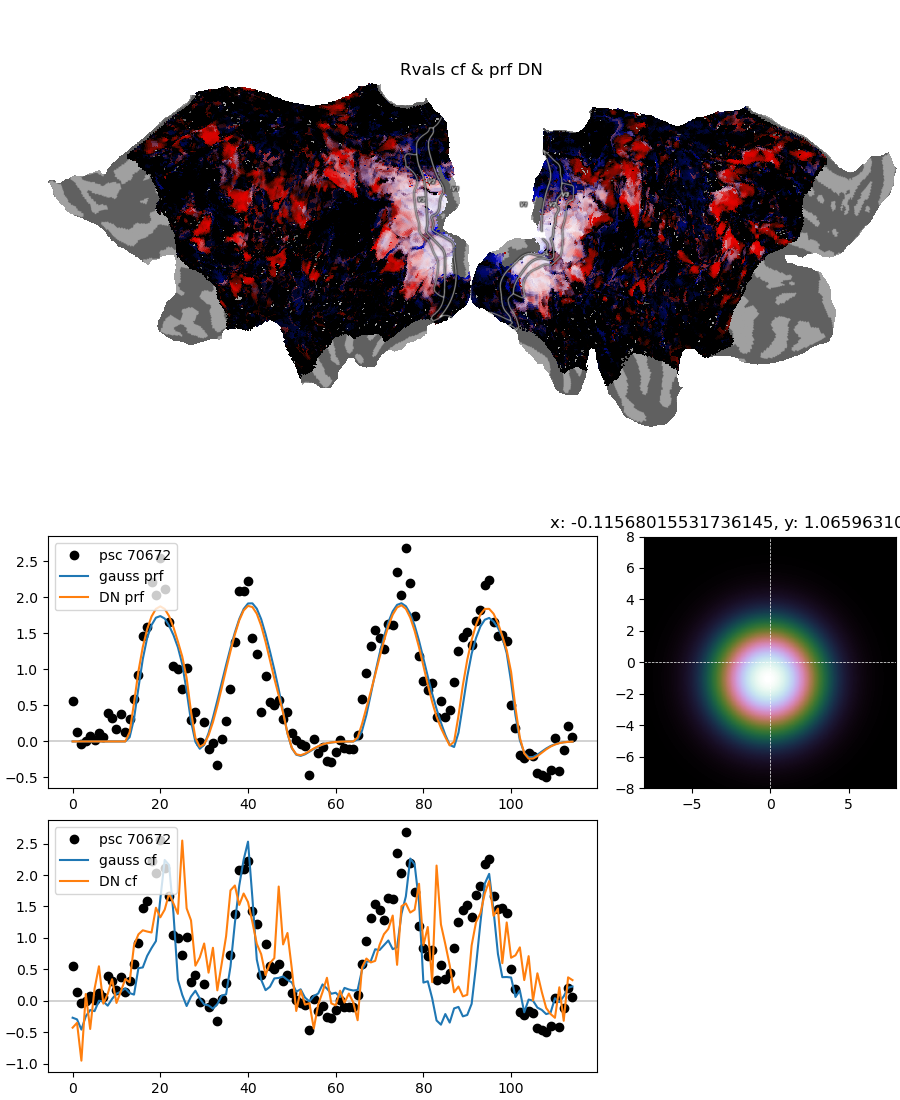

In [22]:
## subject = 'hcp_999999'
%matplotlib notebook


full_fig = plt.figure(constrained_layout=True, figsize=full_figsize)
gs = full_fig.add_gridspec(4, 3)
flatmap_ax = full_fig.add_subplot(gs[:2, :])
timecourse_ax = full_fig.add_subplot(gs[2, :2])
prf_ax = full_fig.add_subplot(gs[2, 2])
flatmap_ax.set_title('flatmap')
timecourse_ax.set_title('timecourse')
prf_ax.set_title('prf')

timecourse_ax2 = full_fig.add_subplot(gs[3, :2])
timecourse_ax2.set_title('timecourse2')


###################################################################################################
###################################################################################################
#######
# redraw per-vertex data
#######
###################################################################################################
###################################################################################################

def redraw_vertex_plots(vertex, refresh):
    if refresh:
        timecourse_ax.clear()
#         flatmap_ax.clear()
    timecourse_ax.axhline(0, color='black', lw=0.25)
    timecourse_ax.plot(psc_data[vertex], 'ko', label = f'psc {vertex}')
    timecourse_ax.plot(gg.return_prediction(*np.array(prf_gauss)[vertex,:-1].T).T, label = 'gauss prf')
    timecourse_ax.plot(gg_norm.return_prediction(*np.array(prf_dn)[vertex,:-1].T).T, label = f'DN prf')
    timecourse_ax.legend(loc="upper left")
    
    if refresh:
        timecourse_ax2.clear()
    timecourse_ax2.axhline(0, color='black', lw=0.25)
    timecourse_ax2.plot(psc_data[vertex], 'ko', label = f'psc {vertex}')
    timecourse_ax2.plot(modelG.return_prediction(*np.array(cf_gauss)[vertex,:-3].T).T, label = f'gauss cf')
    timecourse_ax2.plot(modelDN.return_prediction(*np.array(cf_dn)[vertex,:-3].T).T, label = f'DN cf')
    timecourse_ax2.legend(loc="upper left")
    
#     timecourse_ax2.plot(gg.return_prediction(*gaussparams[vertex,:-1].T).T, label = 'gauss timecourse')
#     timecourse_ax.set_title(f'(dn: {rvals_dn[vertex,-1]}, gauss: {rvals_gauss[vertex,-1]}')
#     timecourse_ax.plot(sos, alpha=0.125, lw=3, color='gray')
#     timecourse_ax.plot(np.roll(sos,5), alpha=0.25, ls=':', lw=3, color='gray')


    prf = gauss2D_iso_cart(prf_space_x,
                       prf_space_y,
                       [prf_dn['x'][vertex],
                        prf_dn['y'][vertex]],
                       prf_dn['pRF size'][vertex])
    prf_ax.clear()
    prf_ax.imshow(prf, extent=vf_extent+vf_extent, cmap='cubehelix')
    prf_ax.axvline(0, color='white', linestyle='dashed', lw=0.5)
    prf_ax.axhline(0, color='white', linestyle='dashed', lw=0.5)
    prf_ax.set_title(f"x: {prf_dn['x'][vertex]}, y: {prf_dn['y'][vertex]}")

def zoom_to_roi(axis, subject, roi, hem, margin=10.0):
    roi_verts = cx.get_roi_verts(subject, roi)[roi]
    roi_map = cx.Vertex.empty(subject)
    roi_map.data[roi_verts] = 1

    (lflatpts, lpolys), (rflatpts, rpolys) = cx.db.get_surf(subject, "flat",
                                                            nudge=True)
    sel_pts = dict(left=lflatpts, right=rflatpts)[hem]
    roi_pts = sel_pts[np.nonzero(getattr(roi_map, hem))[0], :2]

    xmin, ymin = roi_pts.min(0) - margin
    xmax, ymax = roi_pts.max(0) + margin
    print([xmin, xmax, ymin, ymax])
    axis.axis([xmin, xmax, ymin, ymax])

    return [xmin, xmax, ymin, ymax]

###################################################################################################
###################################################################################################
#######
# actual callback functions
#######
###################################################################################################
###################################################################################################

def onclick(event):
    if event.inaxes == flatmap_ax:
        xmin, xmax = flatmap_ax.get_xbound()
        ax_xrange = xmax-xmin
        ymin, ymax = flatmap_ax.get_ybound()
        ax_yrange = ymax-ymin

        rel_x = int(mask.shape[0] * (event.xdata-xmin)/ax_xrange)
        rel_y = int(mask.shape[1] * (event.ydata-ymin)/ax_yrange)
        clicked_pixel = (rel_x, rel_y)

        clicked_vertex = vc[int(
            mask_index[clicked_pixel[0], clicked_pixel[1]])]

        redraw_vertex_plots(clicked_vertex.indices[0], (event.key == 'shift'))
        plt.draw()

def onkey(event):
    if event.key == '1':  # polar angle
        cx.quickshow(cx.Vertex2D(cf_dn['rsq'], prf_dn['rsq'], subject='hcp_999999', vmin=0, vmax=1, vmin2=0, vmax2=1), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('Rvals cf & prf DN')
    elif event.key == '2':  
        cx.quickshow(cx.Vertex(np.array(cf_dn['rsq']-cf_gauss['rsq']), subject, cmap='spectral_r', vmin=-0.1, vmax=0.1), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('Rsq CF DN - gauss')
    elif event.key == '3':  
        cx.quickshow(cx.Vertex2D(np.log(cf_dn['B']), cf_dn['rsq'], subject, cmap='fire_alpha', vmin=0, vmin2=0,vmax2=1), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('CF B param')
    elif event.key == '4': 
        cx.quickshow(cx.Vertex2D(np.log(prf_dn['B']), prf_dn['rsq'], subject, cmap='fire_alpha', vmin=0, vmin2=0,vmax2=1), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('pRF B param')
    elif event.key == '5': 
        cx.quickshow(cx.Vertex(np.log(cf_dn['D']), cf_dn['rsq'], subject, cmap='plasma_alpha', vmin=0, vmin2=0,vmax2=1), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('CF D param')
    elif event.key == '6': 
        cx.quickshow(cx.Vertex2D(np.log(prf_dn['D']), prf_dn['rsq'], subject, cmap='plasma_alpha', vmin=0, vmin2=0,vmax2=1), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('pRF D param')
    elif event.key == '7':  # ecc
        cx.quickshow(cx.Vertex(np.array(ecc(prf_dn['x'], prf_dn['y'])), subject, cmap='nipy_spectral', vmin=0, vmax=8.4), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('eccentricity')
#     elif event.key == '8':  
#         cx.quickshow(cx.Vertex(b_param, subject, cmap='inferno', vmin=0), with_curvature=True,
#              fig=flatmap_ax, with_colorbar=False)             
#         flatmap_ax.set_title('b_param')        
#     elif event.key == '9':  # d_param
#         cx.quickshow(cx.Vertex(d_param, subject, cmap='inferno', vmin=0), with_curvature=True,
#              fig=flatmap_ax, with_colorbar=False)   
#         flatmap_ax.set_title('d_param')    
#     elif event.key == '8':  # mean_epi
#         cx.quickshow(cx.Vertex(mean_epi, subject='hcp_999999', cmap='YlOrRd'), with_curvature=True,
#              fig=flatmap_ax, with_colorbar=False)   
#         flatmap_ax.set_title('EPI')    
    plt.draw()
    
###################################################################################################
###################################################################################################
#######
# start
#######
###################################################################################################
###################################################################################################
# start with rvals.
rdiff = np.zeros([118584,])
rdiff[:] = np.nan
cx.quickshow(cx.Vertex(rdiff, subject='hcp_999999', vmin=0, vmax=1), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)



# new_bounds  = zoom_to_roi(axis=flatmap_ax, subject=subject,
#             roi='V2', hem='left', margin=10.0)

full_fig.canvas.mpl_connect('button_press_event', onclick)
full_fig.canvas.mpl_connect('key_press_event', onkey)
plt.show()
plt.ion()


In [ ]:
# plt.plot(modelG.return_prediction(*np.array(cf_gauss)[vertex,:-3].T).T, label = f'gauss cf')

In [21]:
cf_dn.loc[83628]

cf size              11.174088
cf amp               31.031481
bold baseline         0.000000
vert             104602.000000
surr amp             65.922337
surr size            17.190458
B                     0.020009
D                     0.471918
rsq                   0.655752
x                     7.033163
y                     5.474131
Name: 83628, dtype: float64